# NPZ model and synthetic observations

## some preparation: 
create synthetic (model-generated) data

In [1]:
%matplotlib notebook
import numpy as np

# specify indices
i_n = 0
i_p = 1
i_z = 2

# specify parameter values
theta = {
    'vmax':0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat':0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz':0.02,        # zooplankton grazing rate
    'mort_p':0.02,      # phytoplankton mortality rate
    'mort_z':0.03,      # zooplankton mortality rate
    'irr':0.8,          # light amplitude
}

# specify model 
def dxdt(x,t,theta):
    '''
    input
    =====
    x: model state
    theta: model parameters
    '''
    light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])
    growth = theta['vmax']*x[i_n]/(theta['nuthalfsat']+x[i_n]) * light * x[i_p]
    grazing = theta['graz']*x[i_p]*x[i_z]
    ploss = theta['mort_p']*x[i_p]
    zloss = theta['mort_z']*x[i_z]*x[i_z]
    return np.array((-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss))

run the model

In [2]:
from scipy.integrate import odeint

# initial conditions
x0 = (0.6,0.15,0.23)

# initialize time vector
t = np.arange(0.0,2*365.0,1.0)

x = odeint(dxdt, x0, t, args=(theta,))

set indices for observation extractions and generate synthetic observations

In [3]:
iobs = np.random.choice(len(t)//10, 20, replace=False)*10
iobs.sort()

iobsvar = np.array([i_p,i_z])
sigma = np.array([0.03,0.03])

tobs = t[iobs]
obs = np.maximum(0.0, x[iobs,:][:,iobsvar] + np.random.normal(size=(iobs.size,iobsvar.size))*sigma)

plot data

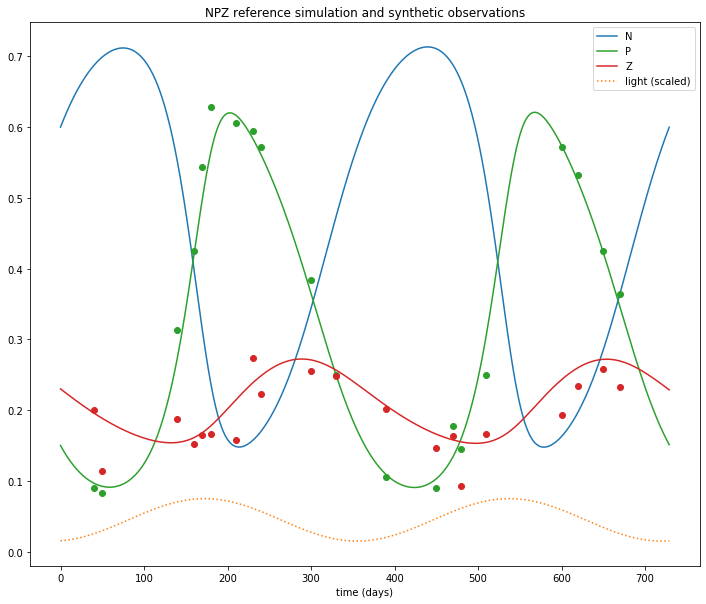

In [4]:
colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,10))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
ax.plot(t,theta['vmax']*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
for i, ivar in enumerate(iobsvar):
    ax.plot(tobs, obs[:,i], color=colors[ivar], marker='o', ls='none')
ax.set(title='NPZ reference simulation and synthetic observations', xlabel='time (days)')
ax.legend()